# Method 5 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

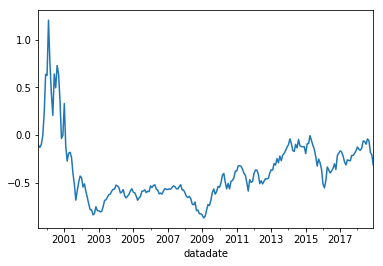

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.639335
2000-12-31   -0.391208
2001-12-31   -0.431159
2002-12-31   -0.639051
2003-12-31    1.100325
2004-12-31    0.009407
2005-12-31   -0.069872
2006-12-31    0.060602
2007-12-31   -0.017771
2008-12-31   -0.593952
2009-12-31    1.688153
2010-12-31    0.348026
2011-12-31   -0.173723
2012-12-31    0.172788
2013-12-31    0.452705
2014-12-31    0.005970
2015-12-31   -0.272596
2016-12-31    0.267804
2017-12-31    0.032145
2018-12-31   -0.181518
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     224.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.69e-78
Time:                        04:21:09   Log-Likelihood:                 337.30
No. Observations:                 234   AIC:                            -664.6
Df Residuals:                     229   BIC:                            -647.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.004      1.142      0.254      -0.003       0.012
mktrf          1.3964      0.108     12.938      0.000       1.184       1.609
me             0.7807      0.126      6.219      0.000       0.533       1.028
ia            -0.4003      0.191     -2.098      0.037      -0.776      -0.024
roe           -1.6514      0.163    -10.111      0.000      -1.973      -1.330
==============================================================================
Omnibus:                      148.821   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2195.332
Skew:                           2.189   Prob(JB):                         0.00
Kurtosis:                      17.353   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     129.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-57
Time:                        04:21:09   Log-Likelihood:                 337.30
No. Observations:                 234   AIC:                            -664.6
Df Residuals:                     229   BIC:                            -647.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.004      1.148      0.251      -0.003       0.012
mktrf          1.3964      0.208      6.723      0.000       0.989       1.804
me             0.7807      0.162      4.812      0.000       0.463       1.099
ia            -0.4003      0.258     -1.550      0.121      -0.906       0.106
roe           -1.6514      0.227     -7.280      0.000      -2.096      -1.207
==============================================================================
Omnibus:                      148.821   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2195.332
Skew:                           2.189   Prob(JB):                         0.00
Kurtosis:                      17.353   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     156.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.87e-64
Time:                        04:21:09   Log-Likelihood:                 337.30
No. Observations:                 234   AIC:                            -664.6
Df Residuals:                     229   BIC:                            -647.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.004      1.074      0.283      -0.004       0.013
mktrf          1.3964      0.209      6.674      0.000       0.986       1.806
me             0.7807      0.174      4.498      0.000       0.441       1.121
ia            -0.4003      0.259     -1.543      0.123      -0.909       0.108
roe           -1.6514      0.243     -6.799      0.000      -2.128      -1.175
==============================================================================
Omnibus:                      148.821   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2195.332
Skew:                           2.189   Prob(JB):                         0.00
Kurtosis:                      17.353   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     168.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.76e-74
Time:                        04:21:09   Log-Likelihood:                 331.68
No. Observations:                 234   AIC:                            -651.4
Df Residuals:                     228   BIC:                            -630.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.876      0.382      -0.004       0.012
mktrf          1.5584      0.111     14.038      0.000       1.340       1.777
smb            0.7965      0.146      5.437      0.000       0.508       1.085
hml            0.0596      0.173      0.345      0.730      -0.281       0.400
rmw           -1.5767      0.195     -8.074      0.000      -1.962      -1.192
cma           -0.0845      0.248     -0.340      0.734      -0.574       0.405
==============================================================================
Omnibus:                      135.648   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1144.987
Skew:                           2.147   Prob(JB):                    2.34e-249
Kurtosis:                      12.950   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     128.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.65e-64
Time:                        04:21:09   Log-Likelihood:                 331.68
No. Observations:                 234   AIC:                            -651.4
Df Residuals:                     228   BIC:                            -630.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.004      0.871      0.384      -0.005       0.012
mktrf          1.5584      0.136     11.481      0.000       1.292       1.824
smb            0.7965      0.143      5.560      0.000       0.516       1.077
hml            0.0596      0.290      0.206      0.837      -0.509       0.628
rmw           -1.5767      0.232     -6.792      0.000      -2.032      -1.122
cma           -0.0845      0.340     -0.248      0.804      -0.751       0.582
==============================================================================
Omnibus:                      135.648   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1144.987
Skew:                           2.147   Prob(JB):                    2.34e-249
Kurtosis:                      12.950   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     144.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-68
Time:                        04:21:09   Log-Likelihood:                 331.68
No. Observations:                 234   AIC:                            -651.4
Df Residuals:                     228   BIC:                            -630.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.005      0.798      0.425      -0.005       0.012
mktrf          1.5584      0.123     12.663      0.000       1.317       1.800
smb            0.7965      0.147      5.415      0.000       0.508       1.085
hml            0.0596      0.241      0.248      0.804      -0.412       0.531
rmw           -1.5767      0.240     -6.560      0.000      -2.048      -1.106
cma           -0.0845      0.307     -0.275      0.783      -0.686       0.517
==============================================================================
Omnibus:                      135.648   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1144.987
Skew:                           2.147   Prob(JB):                    2.34e-249
Kurtosis:                      12.950   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     193.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.38e-72
Time:                        04:21:09   Log-Likelihood:                 323.48
No. Observations:                 234   AIC:                            -637.0
Df Residuals:                     229   BIC:                            -619.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.439      0.661      -0.010       0.006
mktrf          1.7134      0.105     16.254      0.000       1.506       1.921
smb            1.5175      0.132     11.533      0.000       1.258       1.777
hml           -0.3685      0.131     -2.819      0.005      -0.626      -0.111
umd           -0.5301      0.086     -6.181      0.000      -0.699      -0.361
==============================================================================
Omnibus:                      119.617   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.212
Skew:                           1.804   Prob(JB):                    5.92e-226
Kurtosis:                      12.662   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     79.91
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.42e-42
Time:                        04:21:09   Log-Likelihood:                 323.48
No. Observations:                 234   AIC:                            -637.0
Df Residuals:                     229   BIC:                            -619.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.484      0.628      -0.009       0.005
mktrf          1.7134      0.170     10.058      0.000       1.380       2.047
smb            1.5175      0.144     10.541      0.000       1.235       1.800
hml           -0.3685      0.206     -1.790      0.073      -0.772       0.035
umd           -0.5301      0.136     -3.885      0.000      -0.798      -0.263
==============================================================================
Omnibus:                      119.617   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.212
Skew:                           1.804   Prob(JB):                    5.92e-226
Kurtosis:                      12.662   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     78.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.92e-42
Time:                        04:21:09   Log-Likelihood:                 323.48
No. Observations:                 234   AIC:                            -637.0
Df Residuals:                     229   BIC:                            -619.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.472      0.637      -0.009       0.006
mktrf          1.7134      0.168     10.222      0.000       1.385       2.042
smb            1.5175      0.138     11.014      0.000       1.247       1.788
hml           -0.3685      0.199     -1.854      0.064      -0.758       0.021
umd           -0.5301      0.144     -3.671      0.000      -0.813      -0.247
==============================================================================
Omnibus:                      119.617   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.212
Skew:                           1.804   Prob(JB):                    5.92e-226
Kurtosis:                      12.662   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     113.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-39
Time:                        04:21:09   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.007      1.251      0.213      -0.005       0.021
mktrf          1.2487      0.178      7.001      0.000       0.895       1.602
me             0.7388      0.176      4.194      0.000       0.390       1.088
ia            -0.7742      0.276     -2.806      0.006      -1.321      -0.228
roe           -1.6419      0.244     -6.724      0.000      -2.126      -1.158
==============================================================================
Omnibus:                       72.690   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              547.856
Skew:                           1.893   Prob(JB):                    1.08e-119
Kurtosis:                      12.759   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     142.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-43
Time:                        04:21:09   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.006      1.373      0.170      -0.004       0.020
mktrf          1.2487      0.331      3.776      0.000       0.600       1.897
me             0.7388      0.218      3.384      0.001       0.311       1.167
ia            -0.7742      0.354     -2.188      0.029      -1.468      -0.081
roe           -1.6419      0.338     -4.859      0.000      -2.304      -0.980
==============================================================================
Omnibus:                       72.690   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              547.856
Skew:                           1.893   Prob(JB):                    1.08e-119
Kurtosis:                      12.759   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     308.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-60
Time:                        04:21:09   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.006      1.356      0.175      -0.004       0.020
mktrf          1.2487      0.339      3.687      0.000       0.585       1.912
me             0.7388      0.233      3.171      0.002       0.282       1.195
ia            -0.7742      0.325     -2.379      0.017      -1.412      -0.136
roe           -1.6419      0.377     -4.359      0.000      -2.380      -0.904
==============================================================================
Omnibus:                       72.690   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              547.856
Skew:                           1.893   Prob(JB):                    1.08e-119
Kurtosis:                      12.759   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     90.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.01e-38
Time:                        04:21:09   Log-Likelihood:                 153.22
No. Observations:                 120   AIC:                            -294.4
Df Residuals:                     114   BIC:                            -277.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.007      1.313      0.192      -0.005       0.022
mktrf          1.6234      0.188      8.626      0.000       1.251       1.996
smb            0.8370      0.213      3.926      0.000       0.415       1.259
hml           -0.3812      0.261     -1.459      0.147      -0.899       0.136
rmw           -1.2269      0.308     -3.983      0.000      -1.837      -0.617
cma           -0.0887      0.337     -0.263      0.793      -0.757       0.580
==============================================================================
Omnibus:                       75.711   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.540
Skew:                           2.167   Prob(JB):                     2.62e-90
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     87.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-37
Time:                        04:21:09   Log-Likelihood:                 153.22
No. Observations:                 120   AIC:                            -294.4
Df Residuals:                     114   BIC:                            -277.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.005      1.639      0.101      -0.002       0.020
mktrf          1.6234      0.244      6.652      0.000       1.145       2.102
smb            0.8370      0.210      3.985      0.000       0.425       1.249
hml           -0.3812      0.224     -1.704      0.088      -0.819       0.057
rmw           -1.2269      0.321     -3.824      0.000      -1.856      -0.598
cma           -0.0887      0.375     -0.236      0.813      -0.824       0.647
==============================================================================
Omnibus:                       75.711   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.540
Skew:                           2.167   Prob(JB):                     2.62e-90
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     127.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.76e-45
Time:                        04:21:09   Log-Likelihood:                 153.22
No. Observations:                 120   AIC:                            -294.4
Df Residuals:                     114   BIC:                            -277.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.006      1.569      0.117      -0.002       0.020
mktrf          1.6234      0.209      7.764      0.000       1.214       2.033
smb            0.8370      0.205      4.091      0.000       0.436       1.238
hml           -0.3812      0.171     -2.234      0.026      -0.716      -0.047
rmw           -1.2269      0.344     -3.563      0.000      -1.902      -0.552
cma           -0.0887      0.310     -0.286      0.775      -0.696       0.518
==============================================================================
Omnibus:                       75.711   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.540
Skew:                           2.167   Prob(JB):                     2.62e-90
Kurtosis:                      10.982   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     120.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.12e-40
Time:                        04:21:09   Log-Likelihood:                 155.70
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     115   BIC:                            -287.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.006      0.494      0.623      -0.009       0.016
mktrf          1.7289      0.153     11.274      0.000       1.425       2.033
smb            1.4698      0.175      8.418      0.000       1.124       1.816
hml           -0.7369      0.175     -4.214      0.000      -1.083      -0.390
umd           -0.4914      0.108     -4.557      0.000      -0.705      -0.278
==============================================================================
Omnibus:                       70.544   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.542
Skew:                           1.841   Prob(JB):                    2.76e-110
Kurtosis:                      12.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     129.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-41
Time:                        04:21:09   Log-Likelihood:                 155.70
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     115   BIC:                            -287.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.005      0.596      0.551      -0.007       0.013
mktrf          1.7289      0.249      6.955      0.000       1.242       2.216
smb            1.4698      0.139     10.544      0.000       1.197       1.743
hml           -0.7369      0.228     -3.233      0.001      -1.184      -0.290
umd           -0.4914      0.140     -3.506      0.000      -0.766      -0.217
==============================================================================
Omnibus:                       70.544   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.542
Skew:                           1.841   Prob(JB):                    2.76e-110
Kurtosis:                      12.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     259.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.46e-56
Time:                        04:21:09   Log-Likelihood:                 155.70
No. Observations:                 120   AIC:                            -301.4
Df Residuals:                     115   BIC:                            -287.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.005      0.601      0.548      -0.007       0.013
mktrf          1.7289      0.249      6.930      0.000       1.240       2.218
smb            1.4698      0.127     11.606      0.000       1.222       1.718
hml           -0.7369      0.195     -3.788      0.000      -1.118      -0.356
umd           -0.4914      0.156     -3.158      0.002      -0.796      -0.186
==============================================================================
Omnibus:                       70.544   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.542
Skew:                           1.841   Prob(JB):                    2.76e-110
Kurtosis:                      12.346   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     128.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.20e-40
Time:                        04:21:09   Log-Likelihood:                 204.82
No. Observations:                 114   AIC:                            -399.6
Df Residuals:                     109   BIC:                            -386.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.637e-05      0.004     -0.004      0.997      -0.008       0.008
mktrf          1.5718      0.121     13.026      0.000       1.333       1.811
me             0.7285      0.186      3.910      0.000       0.359       1.098
ia             0.3196      0.258      1.237      0.219      -0.193       0.832
roe           -1.7663      0.227     -7.779      0.000      -2.216      -1.316
==============================================================================
Omnibus:                       18.353   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.264
Skew:                           0.709   Prob(JB):                     1.63e-07
Kurtosis:                       5.137   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     110.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-37
Time:                        04:21:09   Log-Likelihood:                 204.82
No. Observations:                 114   AIC:                            -399.6
Df Residuals:                     109   BIC:                            -386.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.637e-05      0.003     -0.005      0.996      -0.006       0.006
mktrf          1.5718      0.140     11.259      0.000       1.298       1.845
me             0.7285      0.249      2.928      0.003       0.241       1.216
ia             0.3196      0.282      1.132      0.258      -0.234       0.873
roe           -1.7663      0.371     -4.765      0.000      -2.493      -1.040
==============================================================================
Omnibus:                       18.353   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.264
Skew:                           0.709   Prob(JB):                     1.63e-07
Kurtosis:                       5.137   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     122.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.92e-39
Time:                        04:21:09   Log-Likelihood:                 204.82
No. Observations:                 114   AIC:                            -399.6
Df Residuals:                     109   BIC:                            -386.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.637e-05      0.003     -0.006      0.995      -0.006       0.006
mktrf          1.5718      0.131     11.959      0.000       1.314       1.829
me             0.7285      0.287      2.534      0.011       0.165       1.292
ia             0.3196      0.304      1.052      0.293      -0.276       0.915
roe           -1.7663      0.379     -4.665      0.000      -2.508      -1.024
==============================================================================
Omnibus:                       18.353   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.264
Skew:                           0.709   Prob(JB):                     1.63e-07
Kurtosis:                       5.137   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     94.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.21e-38
Time:                        04:21:09   Log-Likelihood:                 201.05
No. Observations:                 114   AIC:                            -390.1
Df Residuals:                     108   BIC:                            -373.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.004     -0.598      0.551      -0.011       0.006
mktrf          1.6149      0.119     13.515      0.000       1.378       1.852
smb            0.6620      0.194      3.413      0.001       0.277       1.047
hml            0.8155      0.247      3.296      0.001       0.325       1.306
rmw           -1.5965      0.303     -5.270      0.000      -2.197      -0.996
cma           -0.1438      0.385     -0.374      0.709      -0.906       0.618
==============================================================================
Omnibus:                       22.776   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.595
Skew:                           0.638   Prob(JB):                     2.10e-15
Kurtosis:                       6.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     105.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-40
Time:                        04:21:09   Log-Likelihood:                 201.05
No. Observations:                 114   AIC:                            -390.1
Df Residuals:                     108   BIC:                            -373.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.005     -0.564      0.572      -0.011       0.006
mktrf          1.6149      0.109     14.780      0.000       1.401       1.829
smb            0.6620      0.199      3.326      0.001       0.272       1.052
hml            0.8155      0.214      3.817      0.000       0.397       1.234
rmw           -1.5965      0.375     -4.253      0.000      -2.332      -0.861
cma           -0.1438      0.319     -0.451      0.652      -0.769       0.481
==============================================================================
Omnibus:                       22.776   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.595
Skew:                           0.638   Prob(JB):                     2.10e-15
Kurtosis:                       6.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     122.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.34e-43
Time:                        04:21:09   Log-Likelihood:                 201.05
No. Observations:                 114   AIC:                            -390.1
Df Residuals:                     108   BIC:                            -373.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.004     -0.586      0.558      -0.011       0.006
mktrf          1.6149      0.113     14.254      0.000       1.393       1.837
smb            0.6620      0.221      2.998      0.003       0.229       1.095
hml            0.8155      0.184      4.439      0.000       0.455       1.176
rmw           -1.5965      0.352     -4.538      0.000      -2.286      -0.907
cma           -0.1438      0.330     -0.435      0.663      -0.791       0.504
==============================================================================
Omnibus:                       22.776   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.595
Skew:                           0.638   Prob(JB):                     2.10e-15
Kurtosis:                       6.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     97.11
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.08e-35
Time:                        04:21:09   Log-Likelihood:                 191.84
No. Observations:                 114   AIC:                            -373.7
Df Residuals:                     109   BIC:                            -360.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.005     -0.910      0.365      -0.013       0.005
mktrf          1.6757      0.128     13.078      0.000       1.422       1.930
smb            1.0306      0.200      5.158      0.000       0.635       1.427
hml            0.7626      0.206      3.706      0.000       0.355       1.170
umd           -0.4787      0.155     -3.084      0.003      -0.786      -0.171
==============================================================================
Omnibus:                       28.108   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.204
Skew:                           0.798   Prob(JB):                     2.59e-20
Kurtosis:                       7.055   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     129.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.54e-40
Time:                        04:21:09   Log-Likelihood:                 191.84
No. Observations:                 114   AIC:                            -373.7
Df Residuals:                     109   BIC:                            -360.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.004     -1.045      0.296      -0.012       0.004
mktrf          1.6757      0.122     13.691      0.000       1.436       1.916
smb            1.0306      0.207      4.975      0.000       0.625       1.437
hml            0.7626      0.228      3.350      0.001       0.316       1.209
umd           -0.4787      0.145     -3.312      0.001      -0.762      -0.195
==============================================================================
Omnibus:                       28.108   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.204
Skew:                           0.798   Prob(JB):                     2.59e-20
Kurtosis:                       7.055   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     166.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-45
Time:                        04:21:09   Log-Likelihood:                 191.84
No. Observations:                 114   AIC:                            -373.7
Df Residuals:                     109   BIC:                            -360.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.004     -1.104      0.270      -0.012       0.003
mktrf          1.6757      0.121     13.864      0.000       1.439       1.913
smb            1.0306      0.190      5.413      0.000       0.657       1.404
hml            0.7626      0.229      3.328      0.001       0.313       1.212
umd           -0.4787      0.139     -3.434      0.001      -0.752      -0.205
==============================================================================
Omnibus:                       28.108   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.204
Skew:                           0.798   Prob(JB):                     2.59e-20
Kurtosis:                       7.055   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""